In [1]:
import sys,os,errno,signal,copy
from contextlib import contextmanager
# !pip install intervaltree
import numpy as np
import musicnet

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss, cross_entropy
print(torch.__version__)
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = '/mnt/musicnet/'
checkpoint_path = './checkpoints'
checkpoint = 'musicnet_demo.pt'

try:
    os.makedirs(checkpoint_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

%matplotlib inline

0.3.1


In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1,2,3'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 512
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)/stride

In [3]:
train_set = musicnet.MusicNet(root=root, train=True, download=False, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [4]:
naruto_test = musicnet.MusicNet(root=root, train=False, window=window, download=False, epoch_size=50000, naruto=True)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)
naruto_loader = torch.utils.data.DataLoader(dataset=naruto_test,batch_size=batch_size,**kwargs)

In [6]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [7]:
def L(y_hat, y):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.

def L(y_hat, y):
    # adjust for per-frame loss
    return cross_entropy(y_hat, y.type(torch.cuda.LongTensor))

In [8]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [9]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        
        wsin,wcos = create_filters(d,k)
        with torch.cuda.device(0):
            self.wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
            self.wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
        h1 = 256
        h2 = 256
        self.seq = torch.nn.Sequential()
        conv1_stride = 1
        self.seq.add_module('drop', torch.nn.Dropout())
        self.seq.add_module('bn', torch.nn.BatchNorm1d(k))
        self.seq.add_module('conv1', torch.nn.Conv1d(k, 64, kernel_size = 1, padding=0, stride=1))
        self.seq.add_module('flat', Flatten())
#         self.seq.add_module('conv2', torch.nn.Conv1d(64, 16, kernel_size = 3, padding=1, stride=1))
#         self.seq.add_module('conv3', torch.nn.Conv1d(16, 1, kernel_size = 3, padding=1, stride=1))
        self.seq.add_module('lout', torch.nn.Linear(int(regions*64), int(m), bias=False))
        
#         self.seq.add_module('l1', torch.nn.Linear(int(regions*k), int(h1), bias=False))
#         self.seq.add_module('relu1', torch.nn.ELU())
#         self.seq.add_module('l2', torch.nn.Linear(int(h1), int(h2), bias=False))
#         self.seq.add_module('relu2', torch.nn.ELU())
#         self.seq.add_module('l3', torch.nn.Linear(int(h2), int(m), bias=False))


        self.seq.add_module('out', torch.nn.LogSoftmax())
    
    
#         self.seq.add_module('out', torch.nn.LogSigmoid())
#         self.seq.add_module('out', torch.nn.Sigmoid())
#         self.linear = torch.nn.Linear(int(regions*k), int(h), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear.weight)
#         self.linear2 = torch.nn.Linear(int(h), int(h), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear2.weight)
#         self.linear3 = torch.nn.Linear(int(h), int(m), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear3.weight)
        self.seq.cuda()
        self.avg = avg
        self.averages = copy.deepcopy(list(parm.data for parm in self.parameters()))
        for (name,parm),pavg in zip(self.named_parameters(),self.averages):
            self.register_buffer(name + '.avg', pavg)
    
    def forward(self, x):
#         print(x.size())
        zx = conv1d(x[:,None,:], self.wsin_var, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos_var, stride=stride).pow(2)
#         print(zx.size())
#         hid = self.linear(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],int(regions*k)))
#         hid2 = self.linear2(F.relu(hid))
#         hid3 = self.linear3(F.relu(hid2))
#         return F.softmax(hid3)
#         return self.seq.forward(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],int(regions*k)))
        return self.seq.forward(torch.log(zx + musicnet.epsilon))

    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data)

@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Train the model

In [10]:
model = Model()
print (model)
loss_history = []
avgp_history = []

Model(
  (seq): Sequential(
    (drop): Dropout(p=0.5)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
    (conv1): Conv1d(512, 64, kernel_size=(1,), stride=(1,))
    (flat): Flatten(
    )
    (lout): Linear(in_features=1600, out_features=128, bias=False)
    (out): LogSoftmax()
  )
)


In [11]:
# (optional) restore from checkpoint, if it exists
# try:
#     model.load_state_dict(torch.load(os.path.join(checkpoint_path,checkpoint)))
# except IOError as e:
#     if e.errno != errno.ENOENT:
#         raise

In [12]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=.95)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.MultiLabelSoftMarginLoss()
try:
    with train_set, test_set:
        print ('square loss\tavg prec\ttime\t\tutime')
        for epoch in range(500):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                x, y = Variable(x.cuda(), requires_grad=True), Variable(y.cuda(), requires_grad=False)
#                 print(y.mean())
                #                 loss = L(model(x),y)
                loss = criterion(model(x),y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(test_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
#                     loss += L(yhatvar,y).data[0]
                    loss += criterion(yhatvar,y).data[0]
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print ('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print ('Graceful Exit')
else:
    print ('Finished')

square loss	avg prec	time		utime


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.090126	0.077183	20.438282	7.622451
0.082289	0.254730	19.153247	7.565892
0.074891	0.385710	19.210564	7.489708
0.067440	0.455399	19.385787	7.706076
0.062434	0.497569	19.569596	7.775782
0.058269	0.522529	19.764456	8.098820
0.055500	0.538406	26.831208	9.051709
0.053765	0.552859	26.524648	8.868583
0.051984	0.559788	26.699982	8.689063
0.050982	0.565421	26.576772	8.692123
0.050000	0.566643	27.073449	9.153670
0.049317	0.567365	27.158586	9.216747
0.049018	0.571188	26.699590	8.851467
0.048597	0.571371	27.263025	9.167432
0.048238	0.574418	26.890529	8.681603
0.048242	0.576489	27.218669	9.260910
0.047917	0.574750	26.290356	8.754250
0.047908	0.579043	26.739537	9.037667
0.047817	0.579568	26.457259	9.461015
0.047399	0.578638	25.923908	9.557025
0.047462	0.579622	25.931256	9.545793
0.047509	0.578300	22.651934	7.578634
0.047281	0.576519	19.394806	7.624401
0.047367	0.584422	19.372579	7.426711
0.047260	0.578094	18.897837	7.402127
0.047129	0.580883	18.821566	7.438983
0.047530	0.585549	18.809759	7.369961
0

In [13]:
print(batch_size*len(train_loader))
print(batch_size*len(test_loader))

100000
50000


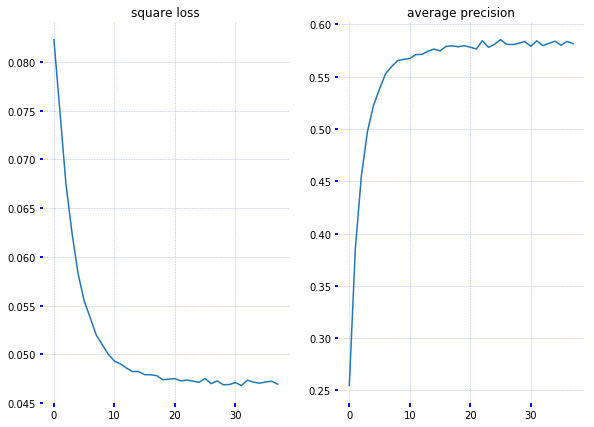

In [14]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])

# Реал тест на наруте

In [15]:

try:
    with train_set, test_set:
        print ('square loss\tavg prec\ttime\t\tutime')
        for epoch in range(50):
            t = time()
            for x, y in train_loader:
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(model(x),y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(naruto_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
                    print(yhatvar)
                    loss += L(yhatvar,y).data[0]
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print ('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print ('Graceful Exit')
else:
    print ('Finished')

square loss	avg prec	time		utime


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


RuntimeError: multi-target not supported at /pytorch/torch/lib/THCUNN/generic/ClassNLLCriterion.cu:16

In [ ]:
! pip indtl

In [ ]:

#!/usr/bin/python

from __future__ import division

import numpy as np
import xgboost as xgb

# label need to be 0 to num_class -1
data = np.loadtxt('./dermatology.data', delimiter=',',
        converters={33: lambda x:int(x == '?'), 34: lambda x:int(x) - 1})
sz = data.shape

train = data[:int(sz[0] * 0.7), :]
test = data[int(sz[0] * 0.7):, :]

train_X = train[:, :33]
train_Y = train[:, 34]

test_X = test[:, :33]
test_Y = test[:, 34]

xg_train = xgb.DMatrix(train_X, label=train_Y)
xg_test = xgb.DMatrix(test_X, label=test_Y)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 6
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 6

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 5
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != test_Y) / test_Y.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(xg_test).reshape(test_Y.shape[0], 6)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test_Y) / test_Y.shape[0]
print('Test error using softprob = {}'.format(error_rate))